## Introduction  
In this lab, we would like to make an XGBoost model to study the e-commerce behavior from a multi-category store. First, we need to download the data to your local machine, then we will load the data into a Pandas DataFrame.

## Objectives
- Apply XGBoost to an example

## Instruction
* Accept the Kaggle policy and download the data from [Kaggle](https://www.kaggle.com/code/tshephisho/ecommerce-behaviour-using-xgboost/data)
* For the first model you will only use the 2019-Nov csv data (which is still around ~2gb zipped)

In [112]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime

In [113]:
# fill this in with your path (absolute path works as well)
path_to_file = "2019-Nov.csv"
df = pd.read_csv(path_to_file)

Start with some exploratory analysis. First, take a look at the first five rows of the DataFrame. Then get the information about the DataFrame, what is the shape of the DataFrame, and what are the coumn names?

In [114]:
df = df.iloc[:1000,:]

In [115]:
# your code
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [116]:
# your code
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_time     1000 non-null   object 
 1   event_type     1000 non-null   object 
 2   product_id     1000 non-null   int64  
 3   category_id    1000 non-null   int64  
 4   category_code  617 non-null    object 
 5   brand          819 non-null    object 
 6   price          1000 non-null   float64
 7   user_id        1000 non-null   int64  
 8   user_session   1000 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB


In [117]:
# your code
df.shape

(1000, 9)

In [118]:
# your code
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

# Know your Customers
How many unique customers visit the site? Assign the number of visitors to the visitor variable and print it out

In [119]:
# your code
visitor = len(df.user_id.value_counts())
print(visitor)

296


# Visitors Daily Trend
Does traffic fluctuate by date? Try using the `event_time` and `user_id` to see traffic. First you need to select by `event_time` and `user_id`, then you will `drop_duplicates` and `groupby` `event_time` and `user_id`.

In [120]:
d = df.loc[:, ["event_time", "user_id"]]
d["event_time"] = d["event_time"].apply(lambda s: str(s)[0:10])
visitor_by_date = (
    d.drop_duplicates()
    .groupby(["event_time"])["user_id"]
    .agg(["count"])
    .sort_values(by=["event_time"], ascending=True)
)
x = pd.Series(visitor_by_date.index.values).apply(
    lambda s: datetime.strptime(s, "%Y-%m-%d").date()
)
y = visitor_by_date["count"]

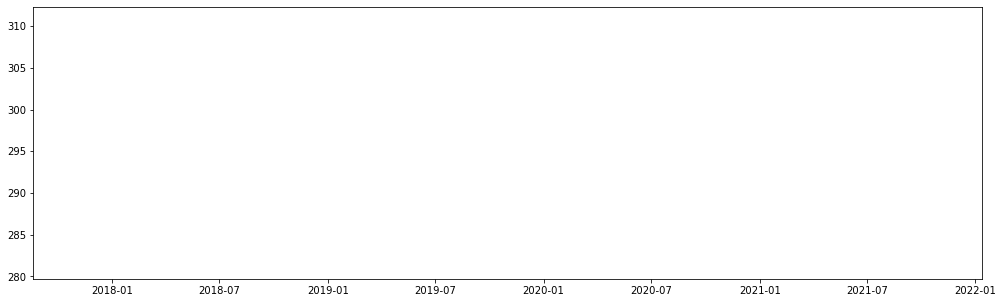

In [121]:
plt.rcParams["figure.figsize"] = (17, 5)
plt.plot(x, y)
plt.show()

### By Category and Product
Which category do customers interact with the most? What brand do they view the most? You can choose just the categories with at least 30 records in order to construct the plots.

In [122]:
max_category_num = 30
top_category = (
    df.loc[:, "category_code"]
    .value_counts()[:max_category_num]
    .sort_values(ascending=False)
)

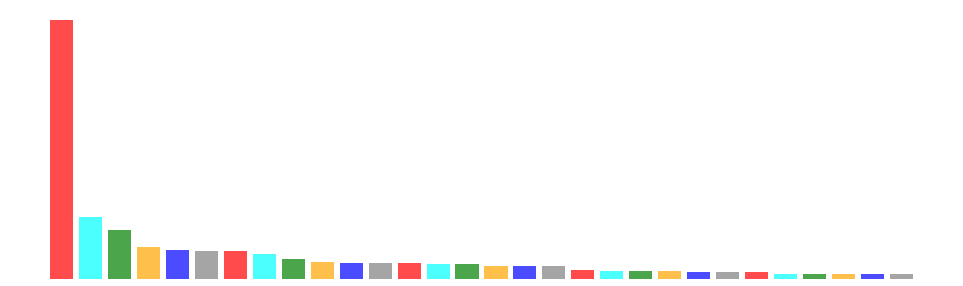

In [123]:
plt.bar(
    height=top_category,
    x=top_category.index.array,
    color=["red", "cyan", "green", "orange", "blue", "grey"],
    alpha=0.7,
)
plt.axis("off")
plt.show()

## Purchases

When the event_type is "purchase", what item do customers buy?

Try using `'event_type' == 'purchase'` and drop empty rows to assess which categories customers buy.

In [124]:
# your code
purchases = df.loc[df.event_type == "purchase"]
purchases = purchases.dropna(axis=0)
purchases.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
168,2019-11-01 00:01:04 UTC,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d
707,2019-11-01 00:04:51 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,128.42,562958505,0f039697-fedc-40fa-8830-39c1a024351d
939,2019-11-01 00:06:33 UTC,purchase,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e
942,2019-11-01 00:06:34 UTC,purchase,5800823,2053013553945772349,electronics.audio.subwoofer,nakamichi,123.56,514166940,8ef5214a-86ad-4d0b-8df3-4280dd411b47


## What brands do the customers buy?
Try grouping by brand and sorting the values by the brand name.

In [125]:
# your code
purchasesByBrand = purchases.groupby("brand")["brand"].agg(["count"]).sort_values("count", ascending=False)

In [126]:
purchasesByBrand.head()

,count
brand,
samsung,2
nakamichi,1
xiaomi,1


In [127]:
del d  # free memory

# Modeling: predict at the time of addition to a shopping cart if the user will purchase a given product or not

### Feature engineering

The goal of this modeling is to predict if the user will purchase a product or not when they add the product to the cart. This is called `cart abandonment` if the user does not purchase.

First, reconstruct and restructure the data to feed into the machine learning model. For this use case, target only the data for which customers have "put" the product into the cart. The relevant `event_type`s are thus "cart" and "purchase".

Create these new features in the training data set:
- `activity_count`: number of activity in that session
- `category_level1`: category
- `category_level2`: sub-category --> split on the "." in the category name
- `weekday`: weekday of the event --> convert `event_time` to a datetime object, then use `pandas.Timestamp.weekday`
- `is_purchased`: whether the is purchased after being put in the cart, this will be the categorical output.

Make sure to de-dup any record.

**Prepare a dataframe for counting activity in the session**

In [128]:
# your code
# first just eliminate the records where event_type = "view" and drop NA values and duplicates
df_targets = df.loc[df["event_type"].isin(["cart", "purchase"])].drop_duplicates(
    subset=["event_type", "product_id", "price", "user_id", "user_session"]
)
cart_purchase_users = df.loc[
    df["event_type"].isin(["cart", "purchase"])
].drop_duplicates(subset=["user_id"])
cart_purchase_users.dropna(how="any", inplace=True)
cart_purchase_users_all_activity = df.loc[
    df["user_id"].isin(cart_purchase_users["user_id"])
]

In [129]:
# now you get the number of activities by user session

activity_in_session = (
    cart_purchase_users_all_activity.groupby(["user_session"])["event_type"]
    .count()
    .reset_index()
)
activity_in_session = activity_in_session.rename(
    columns={"event_type": "activity_count"}
)
df_targets = cart_purchase_users_all_activity.copy()

In [130]:
# create the two new columns for the category levels 1 and 2
# your code here
df_targets["category_level1"] = (
    df_targets["category_code"].str.split(".", expand=True)[0].astype("category")
)
df_targets["category_level2"] = (
    df_targets["category_code"].str.split(".", expand=True)[1].astype("category")
)

In [131]:
# Change the event_time to a timestamp
# your code
df_targets["timestamp"] = pd.to_datetime(df_targets["event_time"])

In [132]:
# Use pandas.dt.dayofweek to get the day of the week
# your code
df_targets["weekday"] = df_targets["timestamp"].dt.dayofweek

In [133]:
# add the is_purchased feature
# your code
df_targets["is_purchased"] = np.where(df_targets["event_type"] == "purchase", 1, 0)
df_targets["is_purchased"] = df_targets.groupby(["user_session", "product_id"])[
    "is_purchased"
].transform("max")

In [134]:
df_targets = df_targets.merge(activity_in_session, on="user_session", how="left")
df_targets["activity_count"] = df_targets["activity_count"].fillna(0)
df_targets["brand"] = df_targets["brand"].astype("category")
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_level1,category_level2,timestamp,weekday,is_purchased,activity_count
0,2019-11-01 00:00:14 UTC,view,1002544,2053013555631882655,electronics.smartphone,apple,458.28,549256216,dcbdc6e4-cd49-4ee8-95c5-e85f3c618fa1,electronics,smartphone,2019-11-01 00:00:14+00:00,4,0,10
1,2019-11-01 00:00:14 UTC,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.09,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a,electronics,smartphone,2019-11-01 00:00:14+00:00,4,0,1
2,2019-11-01 00:00:17 UTC,view,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d,electronics,smartphone,2019-11-01 00:00:17+00:00,4,1,2
3,2019-11-01 00:01:04 UTC,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d,electronics,smartphone,2019-11-01 00:01:04+00:00,4,1,2
4,2019-11-01 00:01:26 UTC,view,1002528,2053013555631882655,electronics.smartphone,apple,617.52,549256216,dcbdc6e4-cd49-4ee8-95c5-e85f3c618fa1,electronics,smartphone,2019-11-01 00:01:26+00:00,4,0,10


### Save new data structure if desired

In [135]:
# df_targets.to_csv('training_data.csv')

In [136]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 27
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   event_time       28 non-null     object             
 1   event_type       28 non-null     object             
 2   product_id       28 non-null     int64              
 3   category_id      28 non-null     int64              
 4   category_code    28 non-null     object             
 5   brand            28 non-null     category           
 6   price            28 non-null     float64            
 7   user_id          28 non-null     int64              
 8   user_session     28 non-null     object             
 9   category_level1  28 non-null     category           
 10  category_level2  28 non-null     category           
 11  timestamp        28 non-null     datetime64[ns, UTC]
 12  weekday          28 non-null     int64              
 13  is_purchased     28 no

In [137]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

## Resampling training set

In [138]:
is_purcahase_set = df_targets[df_targets["is_purchased"] == 1]
is_purcahase_set.shape[0]

10

In [139]:
not_purcahase_set = df_targets[df_targets["is_purchased"] == 0]
not_purcahase_set.shape[0]

18

In [143]:
n_samples = 10
is_purchase_downsampled = resample(
    is_purcahase_set, replace=False, n_samples=n_samples, random_state=27
)
not_purcahase_set_downsampled = resample(
    not_purcahase_set, replace=False, n_samples=n_samples, random_state=27
)

In [144]:
downsampled = pd.concat([is_purchase_downsampled, not_purcahase_set_downsampled])
downsampled["is_purchased"].value_counts()

1    10
0    10
Name: is_purchased, dtype: int64

In [145]:
# select the brand, price, weekday, category_level1, cateogry_level2, and activity_count features

features = downsampled.loc[
    :,
    [
        "brand",
        "price",
        "weekday",
        "category_level1",
        "category_level2",
        "activity_count",
    ]
]

## Encode categorical variables

In [146]:
features.loc[:, "brand"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "brand"].copy()
)
features.loc[:, "weekday"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "weekday"].copy()
)
features.loc[:, "category_level1"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "category_level1"].copy()
)
features.loc[:, "category_level2"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "category_level2"].copy()
)

is_purchased = LabelEncoder().fit_transform(downsampled["is_purchased"])
features.head()

,brand,price,weekday,category_level1,category_level2,activity_count
14,2,128.42,0,0,2,4
8,2,488.80,0,0,3,3
25,1,123.56,0,0,0,2
3,3,211.92,0,0,2,2
16,2,128.42,0,0,2,4


In [147]:
df_targets = df.loc[df["event_type"].isin(["cart", "purchase"])].drop_duplicates(
    subset=["event_type", "product_id", "price", "user_id", "user_session"]
)
cart_purchase_users = df.loc[
    df["event_type"].isin(["cart", "purchase"])
].drop_duplicates(subset=["user_id"])
cart_purchase_users.dropna(how="any", inplace=True)
cart_purchase_users_all_activity = df.loc[
    df["user_id"].isin(cart_purchase_users["user_id"])
]

In [148]:
df_targets["category_level1"] = (
    df_targets["category_code"].str.split(".", expand=True)[0].astype("category")
)
df_targets["category_level2"] = (
    df_targets["category_code"].str.split(".", expand=True)[1].astype("category")
)

In [149]:
df_targets["timestamp"] = pd.to_datetime(df_targets["event_time"])

In [150]:
df_targets["weekday"] = df_targets["timestamp"].dt.dayofweek

In [151]:
df_targets["is_purchased"] = np.where(df_targets["event_type"] == "purchase", 1, 0)
df_targets["is_purchased"] = df_targets.groupby(["user_session", "product_id"])[
    "is_purchased"
].transform("max")

In [152]:
print(list(features.columns))

['brand', 'price', 'weekday', 'category_level1', 'category_level2', 'activity_count']


In [153]:
features.dtypes

brand                int32
price              float64
weekday              int64
category_level1      int32
category_level2      int32
activity_count       int64
dtype: object

## Split the data
Use a test size of 0.3 and a random state of 86 to split the data into test and train subsets

In [154]:
X_train, X_test, y_train, y_test = train_test_split(
    features, is_purchased, test_size=0.3, random_state=86
)

## Train the model
Choose learning rate of 0.1 on XGBClassifier, fit the model, and make predictions on the test set

In [155]:
from xgboost import XGBClassifier

model = XGBClassifier(learning_rate=0.1)
# fit the model on the train sets
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [156]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("fbeta:", metrics.fbeta_score(y_test, y_pred, average="weighted", beta=0.5))

Accuracy: 0.6666666666666666
Precision: 0.6
Recall: 1.0
fbeta: 0.6832298136645963


## Feature importance
Plot the feature importance using plot_importance

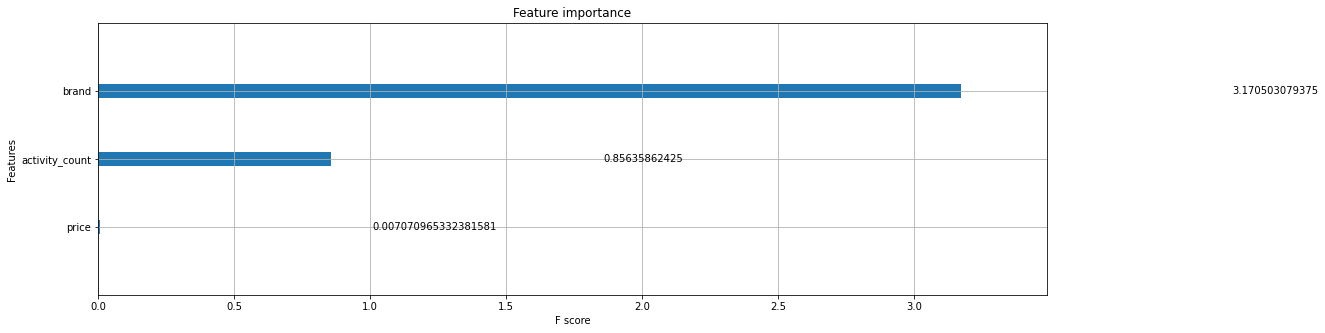

In [157]:
plot_importance(model, max_num_features=10, importance_type="gain")
# plt.rcParams['figure.figsize'] = (40,10)
plt.show()